## Goal : look at how cosmology differences and librairies impact distances estimations

In [1]:
import numpy as np
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import pandas as pd
from astropy.cosmology import LambdaCDM
from clevar.cosmology import AstroPyCosmology
cosmo = AstroPyCosmology()
from clmm import Cosmology
from astropy import units as u
import clevar.cosmology.parent_class as cl_tools
from astropy.coordinates import SkyCoord

/sps/lsst/users/namourou/conda_clone_021023/desc_v0/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/theory/__init__.py:91: UserWarning: CLMM Backend requested 'ccl' is not available, trying others...
/sps/lsst/users/namourou/conda_clone_021023/desc_v0/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/theory/__init__.py:96: UserWarning: * NumCosmo BACKEND also not available


## Looking at z -> Dang[Mpc]

In [2]:
cosmo_clevar = cosmo
cosmo_clevar_hand = LambdaCDM(H0= 70.0, Om0= 0.05 + 0.25, Ob0= 0.05, Tcmb0= 2.7255, Neff= 3.046, m_nu= ([0.06, 0.0, 0.0] * u.eV), Ode0=0.7)
cosmo_matteo = LambdaCDM(H0= 70.0, Om0= 0.3, Ode0=0.7) #from file given by Matteo
cosmo_clmm =  Cosmology(H0=70.0, Omega_b0=0.05, Omega_dm0 = 0.25, Omega_k0=0.0)

In [3]:
#Get clevar cosmo parametters
keys = ["H0", "h", "Omega_k0", "Omega_dm0","Omega_b0","Omega_m0"]
for key in keys :
    print(f"{key} = {cosmo._get_param(key)}")

H0 = 70.0
h = 0.7
Omega_k0 = 0.0
Omega_dm0 = 0.25
Omega_b0 = 0.05
Omega_m0 = 0.3


In [5]:
cosmo_values = pd.read_csv('/pbs/home/n/namourou/workspace/side_codes/clusters/amico/verifications/verif_members/model_SUB_i_greta_t5_param.txt', sep="  ")
cosmo_values = Table.from_pandas(cosmo_values)

/tmp/ipykernel_176/2900634211.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cosmo_values = pd.read_csv('/pbs/home/n/namourou/workspace/side_codes/clusters/amico/verifications/verif_members/model_SUB_i_greta_t5_param.txt', sep="  ")


In [6]:
z_dist_matteo_params = cosmo_matteo.angular_diameter_distance(z=cosmo_values['z'])
#z_dist_clevar_params = cosmo_clevar.eval_da(cosmo_values['z']) #Gives out of hand results
z_dist_clevar_params_hand = cosmo_clevar_hand.angular_diameter_distance(z=cosmo_values['z'])
z_dist_clmm_params = cosmo_clmm.eval_da(cosmo_values['z'])

In [7]:
#plt.plot(cosmo_values['z'], cosmo_values['Dang[Mpc]'], label = 'dist_Matteo')
#plt.plot(cosmo_values['z'], z_dist_clevar_params, label = 'clevar_dist')
#plt.legend()
#plt.xlabel('z')
#plt.ylabel('Dang [Mpc]')

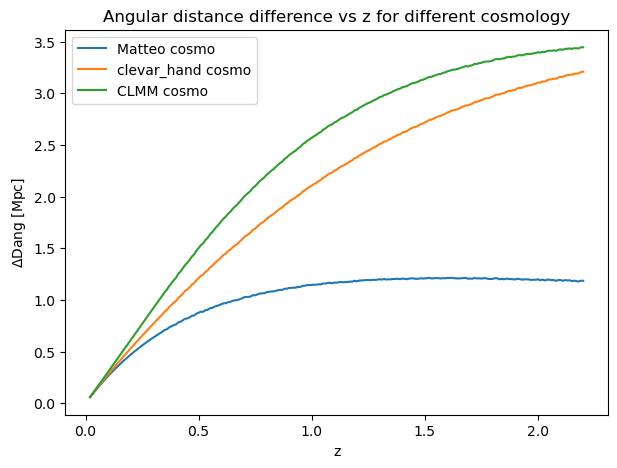

In [8]:
plt.figure(figsize=(7,5))
plt.plot(cosmo_values['z'], cosmo_values['Dang[Mpc]']*u.Mpc-z_dist_matteo_params, label = 'Matteo cosmo')
#plt.plot(cosmo_values['z'], cosmo_values['Dang[Mpc]']*u.Mpc-z_dist_clevar_params*u.Mpc, label = 'clevar cosmo')
plt.plot(cosmo_values['z'], cosmo_values['Dang[Mpc]']*u.Mpc-z_dist_clevar_params_hand, label = 'clevar_hand cosmo')
plt.plot(cosmo_values['z'], cosmo_values['Dang[Mpc]']*u.Mpc-z_dist_clmm_params*u.Mpc, label = 'CLMM cosmo')
plt.xlabel('z')
plt.ylabel('$\Delta$Dang [Mpc]')
plt.title('Angular distance difference vs z for different cosmology')
plt.legend()

Conclusion : Using Matteos cosmo, we find Dang out of z with less than 1% discrepancy

## Now looking at distances member-cluster

In [9]:
mb_inpath = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/AMICO/raw_amico_cats/test_cosmoDC2_compute_lambstar/9559_map_associations_w_mag.fits'
raw_mb_inpath = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/AMICO/raw_amico_cats/test_cosmoDC2_compute_lambstar/9559_map_associations_noBuffer.fits'
neighbours_path = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/CosmoDC2/cosmodc2_neighbours.fits'
healpath = '/sps/lsst/users/tguillem/web/clusters/catalogs/cosmoDC2_photoz_flexzboost/v1/'
inpath = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/AMICO/raw_amico_cats/test_cosmoDC2_compute_lambstar/9559_map_detections_refined_noBuffer.txt'
# = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/AMICO/amico_cats/small/amico_map_associations/all_maps.fits'

In [10]:
cl_cat = pd.read_csv(inpath, sep="\t", header = 243)
cl_cat = Table.from_pandas(cl_cat)
mb = Table.read(mb_inpath)

In [11]:
cl = cl_cat[cl_cat['# ID']==119]
mbs_of_this_cl = mb[mb['ASSOC_ID']==119]
ra_cl, dec_cl, z_cl = cl['Xphys'], cl['Yphys'], cl['Zphys']
ra_mb, dec_mb, z_mb = mbs_of_this_cl['ra'], mbs_of_this_cl['dec'], mbs_of_this_cl['redshift']

In [12]:
ra_dist_clmm = cosmo_clmm.rad2mpc(abs(ra_cl[0]-ra_mb)*np.pi/180, z_cl[0])
dec_dist_clmm = cosmo_clmm.rad2mpc(abs(dec_cl[0]-dec_mb)*np.pi/180, z_cl[0])
z_dist_clmm = cosmo_clmm.eval_da(z=z_cl)-cosmo_clmm.eval_da(z=z_mb)

In [13]:
ra_dist_clevar = cosmo_clevar.rad2mpc(abs(ra_cl[0]-ra_mb)*np.pi/180, z_cl[0])
dec_dist_clevar = cosmo_clevar.rad2mpc(abs(dec_cl[0]-dec_mb)*np.pi/180, z_cl[0])
z_dist_clevar = cosmo_clevar.eval_da(z=z_cl)-cosmo_clevar.eval_da(z=z_mb)

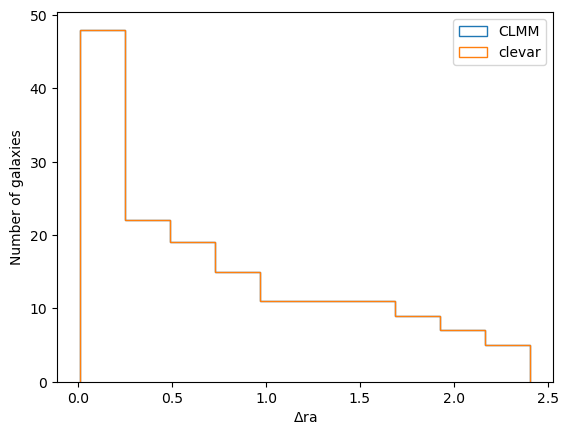

In [14]:
plt.hist(ra_dist_clmm, histtype = 'step', label = "CLMM")
plt.hist(ra_dist_clevar, histtype = 'step', label = "clevar")
plt.xlabel('$\Delta$ra')
plt.ylabel("Number of galaxies")
plt.legend()

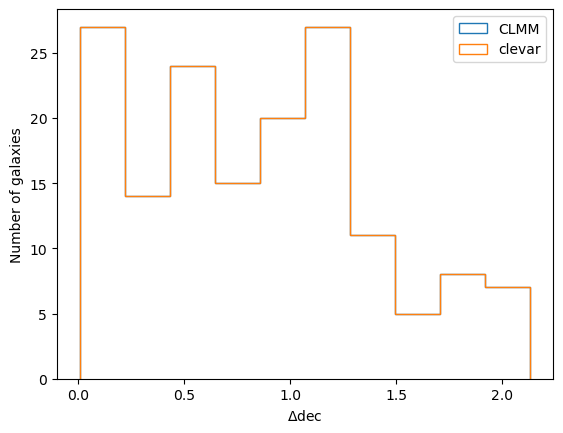

In [15]:
plt.hist(dec_dist_clmm, histtype = 'step', label = "CLMM")
plt.hist(dec_dist_clevar, histtype = 'step', label = "clevar")
plt.xlabel('$\Delta$dec')
plt.ylabel("Number of galaxies")
plt.legend()

Looks like distance don't depend on the package used

## Computing distances in two ways if cosmo is ok cuts must be the same

In [16]:
dist_clmm = np.sqrt((dec_dist_clmm)**2 + (dec_dist_clmm)**2)

Text(0, 0.5, 'Number of galaxies')

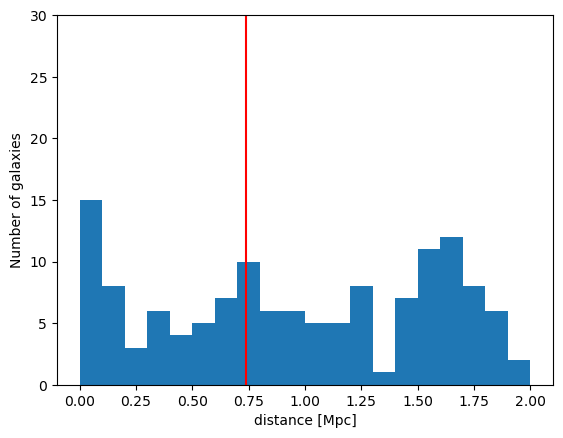

In [17]:
plt.hist(dist_clmm, bins = np.linspace(0,2.0, 21))
plt.vlines(cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]'][0], 0,50, color='red')
plt.ylim([0,30])
plt.xlabel('distance [Mpc]')
plt.ylabel('Number of galaxies')

In [18]:
dist_ang = np.sqrt((ra_cl[0]-ra_mb)**2 + (dec_cl[0]-dec_mb)**2)

Text(0, 0.5, 'Number of galaxies')

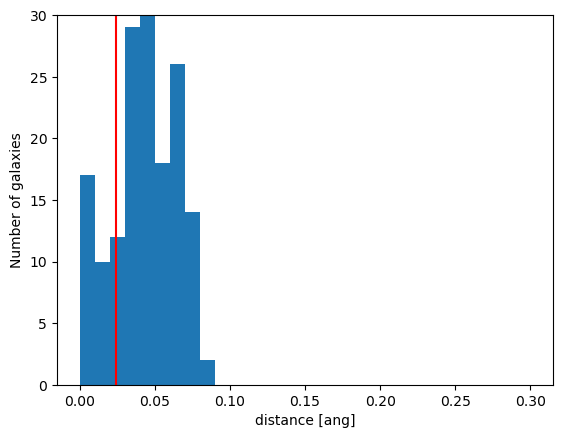

In [19]:
plt.hist(dist_ang, bins = np.linspace(0,0.3, 31))
plt.vlines(cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]'], 0,50, color='red')
plt.ylim([0,30])
plt.xlabel('distance [ang]')
plt.ylabel('Number of galaxies')

In [20]:
len(dist_clmm), len(dist_ang), len(dist_clmm[dist_clmm<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]'][0]]), len(dist_ang[dist_ang<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]'][0]])

(158, 158, 51, 32)

In [25]:
i, j, w = 0, 0, 0
cdt_mpc = dist_clmm[dist_clmm<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]'][0]]
cdt_ang = dist_ang[dist_ang<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]'][0]]
mbs_mpc_c = [mbs_of_this_cl[dist_clmm<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]']]['GALID'][i] for i in range(len(cdt_mpc))]
mbs_ang_c = [mbs_of_this_cl[dist_ang<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]']]['GALID'][i] for i in range(len(cdt_ang))]
for galidmb in mbs_of_this_cl['GALID']:
    if galidmb in mbs_mpc_c:
        i+=1
    if galidmb in mbs_ang_c:
        j+=1
    if galidmb in mbs_mpc_c and galidmb in mbs_ang_c:
        w +=1

In [26]:
i,j,w

(51, 32, 26)

In [27]:
mb['dist_mpc'] = 0.0
mb['dist_deg'] = 0.0
for i, id in enumerate(cl_cat['# ID']):
    if i%500==0:
        print(i)
    assoc_cl = cl_cat[cl_cat['# ID'] == id]
    assoc_mb = mb[mb['ASSOC_ID']==id]
    ra_cl = assoc_cl['Xphys']
    dec_cl = assoc_cl['Yphys']
    z_cl = assoc_cl['Zphys']
    ra_mb = assoc_mb['ra']
    dec_mb = assoc_mb['dec']
    z_mb = assoc_mb['redshift']
    ra_dist = cosmo_clmm.rad2mpc(abs(ra_cl[0]-ra_mb)*np.pi/180, z_cl[0])
    dec_dist = cosmo_clmm.rad2mpc(abs(dec_cl[0]-dec_mb)*np.pi/180, z_cl[0])
    dist_mpc =  np.sqrt((ra_dist)**2+(dec_dist)**2)
    ra_dist_ang = ra_cl - ra_mb
    dec_dist_ang = dec_cl - dec_mb
    dist_ang = np.sqrt((ra_dist_ang)**2+(dec_dist_ang)**2)
    mb['dist_mpc'][mb['ASSOC_ID']==id] = dist_mpc
    mb['dist_deg'][mb['ASSOC_ID']==id] = dist_ang

0
500
1000
1500
2000
2500
3000
3500


In [28]:
zeros1 = np.zeros(12)
mb_c_mpc = Table(zeros1, names = ('GALID','FIELD_PROB', 'ASSOC_ID', 'ASSOC_PROB', 'ra', 'dec', 'redshift', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'))
mb_c_deg = Table(zeros1, names = ('GALID','FIELD_PROB', 'ASSOC_ID', 'ASSOC_PROB', 'ra', 'dec', 'redshift', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'))
for i in range(len(cosmo_values['z'])-1):
    if i%50==0:
        print(i)
    z_min = cosmo_values['z'][i]
    z_max = cosmo_values['z'][i+1]
    mag_i_max = cosmo_values['mstar'][i+1] + 1.5 
    r200_mpc = cosmo_values['r200[Mpc]'][i+1]
    r200_deg = cosmo_values['r200[deg]'][i+1]
    cdt_mpc = mb[(mb['redshift']<=z_max)*(mb['redshift']>=z_min)*(mb['mag_i']<mag_i_max)*(mb['dist_mpc']<r200_mpc)]
    cdt_deg = mb[(mb['redshift']<=z_max)*(mb['redshift']>=z_min)*(mb['mag_i']<mag_i_max)*(mb['dist_deg']<r200_deg)]
    mb_c_mpc = vstack([mb_c_mpc, cdt_mpc])
    mb_c_deg = vstack([mb_c_deg, cdt_deg])

0
50
100
150
200


In [31]:
cl_cat['lambstarest_mpc'] = 0.0
cl_cat['lambstarest_nomsk_mpc'] = 0.0
cl_cat['lambstarest_deg'] = 0.0
cl_cat['lambstarest_nomsk_deg'] = 0.0
rich = []
for i, id in enumerate(cl_cat['# ID']):
    if i%1000==0:
        print(i)
    cl_cat['lambstarest_nomsk_mpc'][cl_cat['# ID'] == id] = sum(mb_c_mpc[mb_c_mpc['ASSOC_ID']==id]['ASSOC_PROB'])
    cl_cat['lambstarest_mpc'][cl_cat['# ID'] == id] = cl_cat['lambstarest_nomsk_mpc'][cl_cat['# ID']==id]/(1-cl_cat[cl_cat['# ID']==id]['MSKFRC'][0])
    cl_cat['lambstarest_nomsk_deg'][cl_cat['# ID'] == id] = sum(mb_c_deg[mb_c_deg['ASSOC_ID']==id]['ASSOC_PROB'])
    cl_cat['lambstarest_deg'][cl_cat['# ID'] == id] = cl_cat['lambstarest_nomsk_deg'][cl_cat['# ID']==id]/(1-cl_cat[cl_cat['# ID']==id]['MSKFRC'][0])

0
1000
2000
3000


In [32]:
mu_mpc = np.mean((cl_cat["LAMBSTAR"]-cl_cat["lambstarest_mpc"])/cl_cat["LAMBSTAR"])
mu_deg = np.mean((cl_cat["LAMBSTAR"]-cl_cat["lambstarest_deg"])/cl_cat["LAMBSTAR"])
print(mu_mpc, mu_deg)

0.02195131463335069 0.023507605823573592


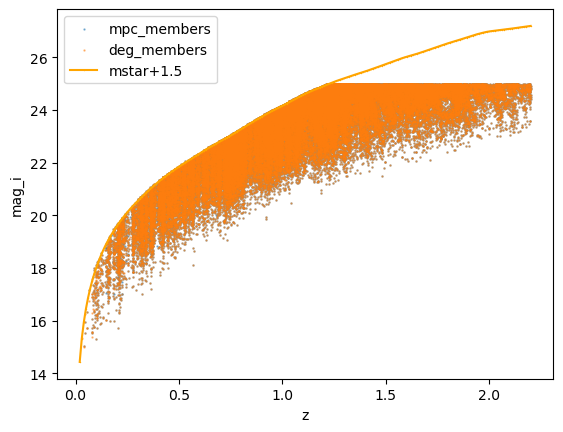

In [33]:
plt.scatter(mb_c_mpc['redshift'][1:], mb_c_mpc['mag_i'][1:], s = .5, alpha = .5, label = "mpc_members")
plt.scatter(mb_c_deg['redshift'][1:], mb_c_deg['mag_i'][1:], s = .5, alpha = .5, label = "deg_members")
plt.plot(cosmo_values['z'], cosmo_values['mstar']+1.5, marker = '+', markersize = .5, alpha = 1, color= 'orange', label = "mstar+1.5")
plt.xlabel("z")
plt.ylabel("mag_i")
plt.legend()

In [34]:
cl_cat[:3]['# ID', 'LAMBSTAR', 'lambstarest_mpc','lambstarest_deg', 'Zphys']

# ID,LAMBSTAR,lambstarest_mpc,lambstarest_deg,Zphys
int64,float64,float64,float64,float64
1,87.619512,77.98231946921105,77.98231946921105,0.57
2,87.87507,63.47849563051652,62.668756818675455,0.42
4,34.050313,25.526884053251514,25.526884053251514,0.46


In [35]:
sig_mpc = np.std((cl_cat["LAMBSTAR"]-cl_cat["lambstarest_mpc"])/cl_cat["LAMBSTAR"])
sig_deg = np.std((cl_cat["LAMBSTAR"]-cl_cat["lambstarest_deg"])/cl_cat["LAMBSTAR"])
print(sig_mpc, sig_deg)

0.21082936312530534 0.2097642498030928


In [36]:
np.mean((cl_cat['lambstarest_mpc'] - cl_cat['lambstarest_deg'])/cl_cat['lambstarest_mpc'])

/tmp/ipykernel_176/3117879076.py:1: RuntimeWarning: invalid value encountered in divide
  np.mean((cl_cat['lambstarest_mpc'] - cl_cat['lambstarest_deg'])/cl_cat['lambstarest_mpc'])


nan

In [37]:
cl_cat[cl_cat['lambstarest_deg']==0]

# ID,Xpix,Ypix,Zpix,Xphys,Yphys,Zphys,SN,SN_NO_CLUSTER,AMP,RICH,LIKE,MSKFRC,POISS,LAMB,LAMBSTAR,ZPIX_SIGM,ZPIX_SIGP,ZPHYS_SIGM,ZPHYS_SIGP,ODDS,Pz-0,Pz-1,Pz-2,Pz-3,Pz-4,Pz-5,Pz-6,Pz-7,Pz-8,Pz-9,Pz-10,Pz-11,Pz-12,Pz-13,Pz-14,Pz-15,Pz-16,Pz-17,Pz-18,Pz-19,Pz-20,Pz-21,Pz-22,Pz-23,Pz-24,Pz-25,Pz-26,Pz-27,Pz-28,Pz-29,Pz-30,Pz-31,Pz-32,Pz-33,Pz-34,Pz-35,Pz-36,Pz-37,Pz-38,Pz-39,Pz-40,Pz-41,Pz-42,Pz-43,Pz-44,Pz-45,Pz-46,Pz-47,Pz-48,Pz-49,Pz-50,Pz-51,Pz-52,Pz-53,Pz-54,Pz-55,Pz-56,Pz-57,Pz-58,Pz-59,Pz-60,Pz-61,Pz-62,Pz-63,Pz-64,Pz-65,Pz-66,Pz-67,Pz-68,Pz-69,Pz-70,Pz-71,Pz-72,Pz-73,Pz-74,Pz-75,Pz-76,Pz-77,Pz-78,Pz-79,Pz-80,Pz-81,Pz-82,Pz-83,Pz-84,Pz-85,Pz-86,Pz-87,Pz-88,Pz-89,Pz-90,Pz-91,Pz-92,Pz-93,Pz-94,Pz-95,Pz-96,Pz-97,Pz-98,Pz-99,Pz-100,Pz-101,Pz-102,Pz-103,Pz-104,Pz-105,Pz-106,Pz-107,Pz-108,Pz-109,Pz-110,Pz-111,Pz-112,Pz-113,Pz-114,Pz-115,Pz-116,Pz-117,Pz-118,Pz-119,Pz-120,Pz-121,Pz-122,Pz-123,Pz-124,Pz-125,Pz-126,Pz-127,Pz-128,Pz-129,Pz-130,Pz-131,Pz-132,Pz-133,Pz-134,Pz-135,Pz-136,Pz-137,Pz-138,Pz-139,Pz-140,Pz-141,Pz-142,Pz-143,Pz-144,Pz-145,Pz-146,Pz-147,Pz-148,Pz-149,Pz-150,Pz-151,Pz-152,Pz-153,Pz-154,Pz-155,Pz-156,Pz-157,Pz-158,Pz-159,Pz-160,Pz-161,Pz-162,Pz-163,Pz-164,Pz-165,Pz-166,Pz-167,Pz-168,Pz-169,Pz-170,Pz-171,Pz-172,Pz-173,Pz-174,Pz-175,Pz-176,Pz-177,Pz-178,Pz-179,Pz-180,Pz-181,Pz-182,Pz-183,Pz-184,Pz-185,Pz-186,Pz-187,Pz-188,Pz-189,Pz-190,Pz-191,Pz-192,Pz-193,Pz-194,Pz-195,Pz-196,Pz-197,Pz-198,Pz-199,Pz-200,Pz-201,Pz-202,Pz-203,Pz-204,Pz-205,Pz-206,Pz-207,Pz-208,Pz-209,Pz-210,Pz-211,Pz-212,Pz-213,Pz-214,Pz-215,Pz-216,Pz-217,Pz-218,Unnamed: 240,lambstarest_mpc,lambstarest_nomsk_mpc,lambstarest_deg,lambstarest_nomsk_deg
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1081,290,243,218,64.788208,-34.664195,2.2,1.5224741,12.99405,2.1757597,9.8250363,168.84533,0.0070334931,0.9878342,2.8379053,1.0015535,6.1412764,4.0041329,0.061412764,0.040041329,0.96246425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

Estimation and discrepancy are close, so we are able to do cut using r200[Mpc]